Тема урока: механизмы очистки памяти
Механизмы очистки памяти
Подсчет ссылок
Сборщик мусора
Модуль gc
Аннотация. Урок посвящен механизмам очистки памяти в Python.

Механизмы очистки памяти

Как мы уже знаем, язык Python является языком с автоматически управляемой памятью, то есть программисту, пишущему код на Python, не нужно беспокоиться о работе с памятью, в частности заниматься ее освобождением. Как только данные программы (объекты в Python) больше не нужны, Python автоматически освобождает память, которую они занимали. Несмотря на это, понимание того, как работает механизм очистки памяти, может помочь писать более качественный и производительный код.

Стандартный интерпретатор Python использует сразу два механизма очистки памяти:

подсчет ссылок
сборщик мусора (Garbage Collector, GC)

Подсчет ссылок

Алгоритм подсчета ссылок — это один из самых простых механизмов очистки памяти. Объекты удаляются как только на них больше нет ссылок.

Каждый объект в Python унаследован от базового класса PyObject, который содержит специальное поле Reference Count (ob_refcnt), в котором хранится количество ссылок на данный объект. Как только кто-то начинает ссылаться на объект, значение этого поля увеличивается на единицу. Если по какой-то причине ссылка пропадает, то это поле уменьшается на один. При этом если счетчик ссылок для определенного объекта достигает нуля, то интерпретатор запускает процесс уничтожения объекта. Если удаленный объект содержал ссылки на другие объекты, то эти ссылки также удаляются. Таким образом, удаление одного объекта может повлечь за собой удаление других.

Механизм подсчета ссылок работает в режиме реального времени.

In [ ]:
import gc

nums = [1, 2, 3]

создает объект, у которого поле Reference Count (ob_refcnt) равно 1.

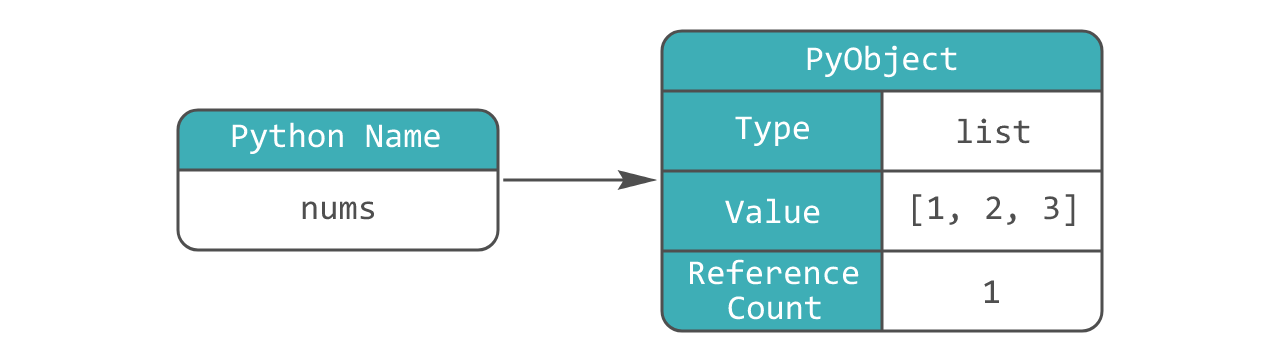

In [1]:
from functions import picture
picture('память8 (1).png')

In [ ]:
nums = [1, 2, 3]
nums1 = nums

создает объект, у которого поле Reference Count (ob_refcnt) равно 2.

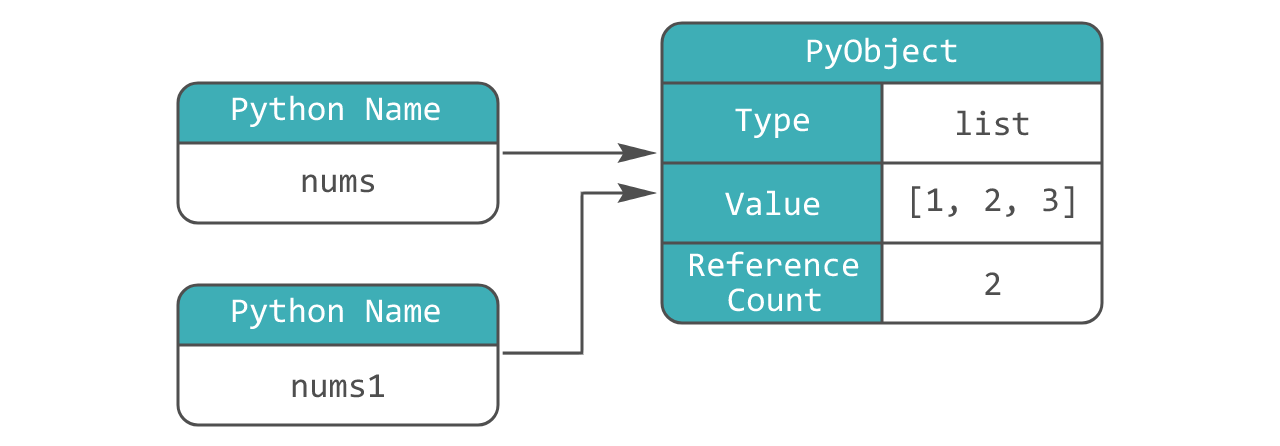

In [2]:
picture('память8.png')

Четыре основных сценария, увеличивающих количество ссылок на объект:

создание нового объекта и присвоение его переменной
присвоение уже существующего объекта переменной
передача объекта в функцию в качестве аргумента
добавление объекта в список, множество, словарь и т.д.

Четыре основных сценария, уменьшающих количество ссылок на объект:

удаление объекта из области видимости функции после ее завершения
удаление переменной с помощью оператора del
переприсваивание переменной нового значения
удаление объекта из списка, множества, словаря и т.д.

Для получения количества ссылок на заданный объект используется функция getrefcount() из модуля sys

In [3]:
import sys

nums = [1, 2, 3] 

print(sys.getrefcount(nums))

2


Когда мы вызываем функцию getrefcount() для получение количества ссылок на объект, мы увеличиваем количество ссылок на объект на один, так как передаем nums в качестве аргумента в функцию. Поэтому счетчик ссылок равен 2. Это означает, что и переменная nums, и функция getrefcount() ссылаются на один и тот же список [1, 2, 3].

Можно поэкспериментировать и написать такой код:

In [4]:
import sys

nums = [1, 2, 3]                            # ссылка 1
nums1 = nums                                # ссылка 2
nums2 = nums1                               # ссылка 3
temp = [4, 5, 6, nums, nums1, nums2]        # ссылка 4, 5, 6
print(sys.getrefcount(nums))                # ссылка 7

7


Алгоритм подсчета ссылок очень простой и эффективный, но у него есть один большой недостаток. Он не умеет определять циклические ссылки.

In [ ]:
nums1 = [1, 2, 3]
nums2 = [4, 5]

nums1.append(nums2)
nums2.append(nums1) 

создает циклические ссылки, так как nums1 содержит ссылку на nums2, в то время как nums2 содержит ссылку на nums1. Таким образом, счетчики ссылок у nums1 и nums2 никогда не будут равны нулю.

In [ ]:
nums = [1, 2, 3]
nums.append(nums)

также создает циклическую ссылку, так как nums содержит ссылку на себя самого.

Именно из-за этого в Python существует дополнительный механизм очистки памяти — сборщик мусора (Garbage Collector, GC), который следит за объектами с потенциальными циклическими ссылками.

В Python алгоритм подсчета ссылок является фундаментальным и не может быть отключен, тогда как сборщик мусора (GC) опционален и может быть отключен.

Сборщик мусора

В отличие от алгоритма подсчета ссылок, сборщик мусора не работает в режиме реального времени и запускается периодически. Каждый запуск сборщика создаёт микропаузы в работе программы, поэтому Python использует различные эвристики для определения частоты запуска сборщика мусора.

Сборщик мусора разделяет все объекты на 3 поколения (нулевое, первое и второе). Новые объекты попадают в нулевое поколение. Если новый объект выживает в процессе сборки мусора, то он перемещается в следующее поколение. Чем старше поколение, тем реже оно сканируется на сборку мусора. Так как новые объекты зачастую имеют очень маленький срок жизни (являются временными), то имеет смысл проверять их чаще, чем те, которые уже прошли через несколько этапов сборки мусора.

В каждом поколении есть специальный порог срабатывания, при достижении которого срабатывает процесс сборки мусора. Если сразу несколько поколений преодолели порог, то выбирается наиболее старшее поколение, так как сборка мусора в старших поколениях включает в себя также сборку мусора и в младших поколениях.

Для взаимодействия со сборщиком мусора используется модуль gc.

Наиболее полезные функции модуля:

gc.enable(): включает сборщика мусора (по умолчанию он включен)
gc.disable(): отключает сборщика мусора
gc.isenabled(): возвращает True, если сборщик мусора включен, или False в противном случае
gc.collect(): запускает сборщика мусора на всех трех поколениях. Функция имеет необязательный аргумент generation (целое число от 0 до 2), указывающий номер поколения, в котором нужно запустить сборщика мусора

In [6]:
import gc

gc.isenabled()

True

In [11]:
gc.collect(2)

542

Примечание 3. Счетчик ссылок подвержен проблемам в многопоточной среде, которые могут приводить к некорректности обновления этого счетчика из разных потоков и, следовательно, к удалению объектов, на которые еще существуют ссылки. Чтобы этого избежать, CPython использует GIL — Global Interpreter Lock. Каждый раз, когда происходит работа с памятью, GIL — как глобальная блокировка — препятствует выполнению этих действий одновременно из двух потоков. Он гарантирует, что сначала отработает один, потом другой.

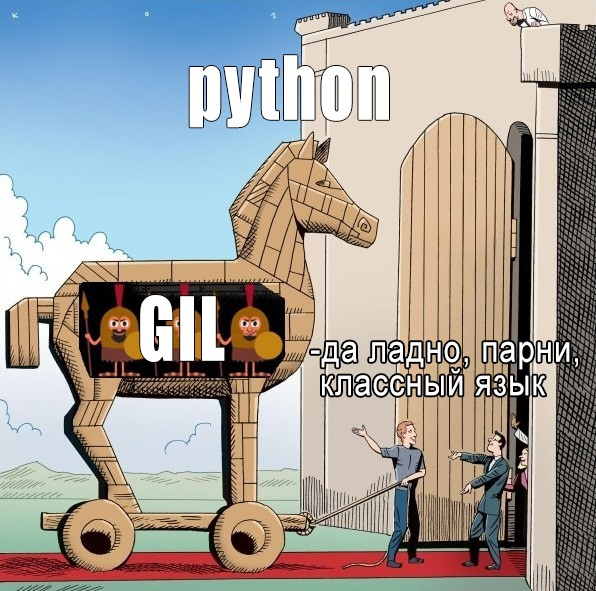

In [13]:
picture('image (1).png')

Почитать подробнее про GIL можно по
https://habr.com/ru/company/wunderfund/blog/586360/

Примечание 4. Количество ссылок на определенный объект иногда может оказаться заметно больше, чем кажется на первый взгляд.

In [25]:
import sys

print(sys.getrefcount(0))     # число 0
print(sys.getrefcount(1))     # число 1
print(sys.getrefcount(''))    # пустая строка
print(sys.getrefcount(()))    # пустой кортеж

4294967295
4294967295
4294967295
4294967295


Дело в том, что многие неизменяемые объекты уже используются, например, в реализациях встроенных функций и типов данных. Объекты, относящиеся к изменяемым типам данных данной особенности не подвержены, так как изменение такого объекта в одной части программы привело бы к его изменению в другой части программы.

In [26]:
import sys

print(sys.getrefcount([]))       # пустой список
print(sys.getrefcount({}))       # пустой словарь
print(sys.getrefcount(set()))    # пустое множество

1
1
1


Примечание 6. При отображении объектов, содержащих циклические ссылки, используется специальная нотация в виде троеточия.

In [27]:
nums = [1, 2, 3]
nums.append(nums)

print(nums)

[1, 2, 3, [...]]


Примечание 7. Помимо обычных ссылок на объект в Python существуют слабые ссылки, которые не увеличивают счетчик ссылок и тем самым не препятствуют удалению объекта. Для работы со слабыми ссылками используется модуль weakref, подробнее о котором можно почитать на русском и английском языках.
https://docs-python.ru/standart-library/modul-weakref-python/
https://docs.python.org/3/library/weakref.html

Примечание 8. Визуализировать граф всех Python объектов можно с помощью модуля objgraph. Данный модуль позволяет создавать изображения наподобие следующего:

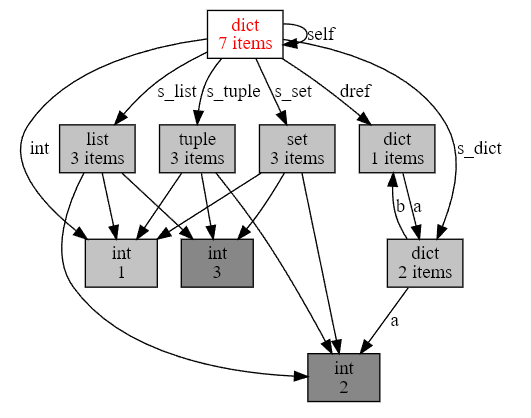

In [36]:
picture('(1).png')

In [46]:
import objgraph

x = []
y = [x, [x], dict(x=x)]

# Путь, куда сохранить изображение
output_path = r"D:\images\sample-graph.png"

# Показать ссылки на y и сохранить граф в указанную папку
objgraph.show_refs([y], filename=output_path)

Graph written to C:\Users\KOVALE~1.KON\AppData\Local\Temp\objgraph-sq9n8o7c.dot (4 nodes)
Image generated as D:\images\sample-graph.png


Примечание 9. PyObject определяется как C структура, которая характерна для CPython (стандартной реализации), и представляет базовую структуру всех объектов Python.

In [43]:
import os

# Путь к Graphviz
graphviz_path = r"C:\Program Files\Graphviz\bin"

# Добавляем путь в переменную среды PATH
os.environ["PATH"] += os.pathsep + graphviz_path

# Проверка
if "dot" in os.popen("where dot").read():
    print("Graphviz добавлен в PATH успешно!")
else:
    print("Не удалось найти Graphviz в PATH.")

Graphviz добавлен в PATH успешно!


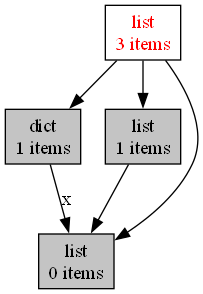

In [48]:
picture('sample-graph.png')